In [1]:
from datasets import get_dataset
from synthcity.utils.serialization import save_to_file, load_from_file
from synthcity.plugins import Plugins
from synthcity.benchmark import Benchmarks
from pathlib import Path
import pandas as pd

import warnings

warnings.filterwarnings("ignore")

In [2]:
out_dir = Path("output")

gain_scenarios = [
    (
        "uncensoring_with_date",
        {
            "uncensoring_model": "date",
            "tte_strategy": "uncensoring",
            "dataloader_sampling_strategy": "none",
            "use_conditional": False,
        },
    ),
    (
        "survival_function_with_date",
        {
            "uncensoring_model": "date",
            "tte_strategy": "survival_function",
            "dataloader_sampling_strategy": "none",
            "use_conditional": False,
        },
    ),
    (
        "survival_function_regression_no_sampling",
        {
            "uncensoring_model": "survival_function_regression",
            "tte_strategy": "survival_function",
            "dataloader_sampling_strategy": "none",
            "use_conditional": False,
        },
    ),
    (
        "survival_function_regression_imbalanced_cens_sampling",
        {
            "uncensoring_model": "survival_function_regression",
            "tte_strategy": "survival_function",
            "dataloader_sampling_strategy": "imbalanced_censoring",
            "use_conditional": False,
        },
    ),
    (
        "survival_function_regression_imbalanced_time_cens_no_cond",
        {
            "uncensoring_model": "survival_function_regression",
            "tte_strategy": "survival_function",
            "dataloader_sampling_strategy": "imbalanced_time_censoring",
            "use_conditional": False,
        },
    ),
    (
        "survival_function_regression_imbalanced_time_cens_sampling",
        {
            "uncensoring_model": "survival_function_regression",
            "tte_strategy": "survival_function",
            "dataloader_sampling_strategy": "imbalanced_time_censoring",
        },
    ),
]


def get_metric(
    dataset: str,
    metric: str,
):
    results = []
    experiment = "sources_of_gain_parametric"

    for scenario_name, scenario_args in gain_scenarios:
        bkp = out_dir / f"experiment_{experiment}_{dataset}_{scenario_name}.bkp"
        df, duration_col, event_col, time_horizons = get_dataset(dataset)

        try:
            score = load_from_file(bkp)
        except BaseException as e:
            print("failed to load file", e)
            continue

        model = "survival_gan"
        method_score = score[model]
        local_df = method_score.loc[metric].copy()
        local_df["model"] = scenario_name
        results.append(local_df.to_frame().T)

    return pd.concat(results, ignore_index=True)

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action="once")

# sns.set_style("white")
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, HTML

fontsize = 10
text_kwargs = dict(fontsize=fontsize)


def generate_plot_for_ax(ax, title, data):
    datasets = data["dataset"].unique()
    datasets_cnt = len(datasets)

    barWidth = 1

    max_val = 0
    idx = 0

    models = [
        "uncensoring_with_date",
        "survival_function_with_date",
        "survival_function_regression_no_sampling",
        "survival_function_regression_imbalanced_cens_sampling",
        "survival_function_regression_imbalanced_time_cens_no_cond",
        "survival_function_regression_imbalanced_time_cens_sampling",
    ]
    cases = [
        ("#30a2da", "uncensoring_with_date"),
        ("#e5ae38", "survival_function_with_date"),
        ("#6d904f", "survival_function_regression_no_sampling"),
        ("#8b8b8b", "survival_function_regression_imbalanced_cens_sampling"),
        ("#ff9cde", "survival_function_regression_imbalanced_time_cens_no_cond"),
        ("#D23e4e", "survival_function_regression_imbalanced_time_cens_sampling"),
    ]
    models_cnt = len(models)

    maxval = 0

    for color, model in cases:
        base_mod_mean = data[data["model"] == model]["mean"]
        base_mod_std = data[data["model"] == model]["std"]
        if len(base_mod_mean) == 0:
            print("invalid model", model)
            continue

        edgecolor = "k"

        idxs = [
            (idx + ((models_cnt + 1) * r)) * barWidth for r in range(len(base_mod_mean))
        ]
        ax.bar(
            idxs,
            base_mod_mean.values,
            yerr=base_mod_std.values,
            width=barWidth,
            label=model,
            edgecolor=edgecolor,
            color=color,
        )

        maxval = max(maxval, max((base_mod_mean + base_mod_std).values))
        idx += 1

    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.2),
        ncol=models_cnt,
        prop={"size": fontsize},
    )

    ax.set_xticks(
        [(models_cnt + 1) * r + int(models_cnt / 2) for r in range(datasets_cnt)],
        datasets,
        rotation=0,
        fontsize=fontsize,
    )
    ax.set_yticks([0.1 * v for v in range(int(10 * maxval) + 2)], fontsize=100)
    ax.set_ylabel(title, fontsize=fontsize)

    ax.tick_params(axis="both", which="major", labelsize=fontsize)

    return ax


def generate_plot(title, data):
    # ['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast',
    #'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']

    plt.style.use("seaborn-whitegrid")

    offset = len(data)
    fig, axs = plt.subplots(1, figsize=(3 * len(data["dataset"].unique()), 3))

    generate_plot_for_ax(axs, title, data)

    plt.subplots_adjust(hspace=0.35)
    plt.savefig(f"diagrams/general_{title}.png")
    plt.show()


def print_performance_table(title, df):
    str_repr = [
        f"{round(m, 4)} +/- {round(s, 4)}"
        for m, s in zip(df["mean"].values, df["std"].values)
    ]
    df["str"] = str_repr
    df = df.drop(columns=["mean", "std"])

    piv = df.pivot_table(
        values="str", index=df["model"], columns="dataset", aggfunc="first"
    )
    display(piv)


def plot_performance(
    datasets: list, title: str, metrics: list, direction: str = "maximize"
):
    headers = ["model", "mean", "std", "dataset"]
    res_df = pd.DataFrame([], columns=headers)

    for dataset in datasets:
        results = []

        for metric in metrics:
            try:
                local_metrics = get_metric(dataset, metric)

                results.append(local_metrics.reset_index(drop=True))
            except BaseException as e:
                print("get metric failed", e)
                continue

        if len(results) == 0:
            continue

        for idx, row in results[0].iterrows():
            local_results = pd.concat(
                [v.iloc[idx].to_frame().T for v in results], ignore_index=True
            )

            if direction == "maximize":
                best_result = local_results[
                    local_results["mean"] == local_results["mean"].max()
                ]
            elif direction == "minimize":
                best_result = local_results[
                    local_results["mean"] == local_results["mean"].min()
                ]
            else:
                raise RuntimeError(f"invalid direction {direction}")

            local_df = pd.DataFrame(
                [
                    [
                        best_result["model"].values[0],
                        best_result["mean"].values[0],
                        best_result["stddev"].values[0],
                        dataset,
                    ]
                ],
                columns=headers,
            )
            res_df = pd.concat([res_df, local_df], ignore_index=True)

    if len(res_df) == 0:
        return res_df

    print("Scenario", title)
    print_performance_table(title, res_df)
    generate_plot(title, res_df)

    print("=" * 100)
    return res_df

## Metrics

In [55]:
from synthcity.utils.serialization import dataframe_hash, load_from_file, save_to_file
import json
from plots import plot_survival_individual, plot_survival_grouped
import matplotlib.pyplot as plt
import pandas as pd
from lifelines import KaplanMeierFitter

workspace = Path("workspace")
plugin = "survival_gan"
repeat = 0


def map_dataset(d):
    if d == "maggic":
        return "pheart"

    return d


def plot_survival_grouped(
    scenario: str,
    title: str,
    T: pd.Series,
    E: pd.Series,
    preds: list,
    ci_show: bool = True,
    ci_alpha: float = 0.2,
    show_censors: bool = False,
) -> None:
    fig, axs = plt.subplots(
        1, len(preds), figsize=(4 * len(preds), 3), constrained_layout=True
    )

    models = []
    for idx, pred in enumerate(preds):
        ax = axs[idx]
        syn_label, syn_T, syn_E = pred
        gt_kmf = KaplanMeierFitter()
        gt_kmf.fit(T, E, label="Real data")  # t = Timepoints, Rx: 0=censored, 1=event
        ax = gt_kmf.plot(
            ax=ax, ci_show=ci_show, ci_alpha=ci_alpha, show_censors=show_censors
        )

        syn_kmf = KaplanMeierFitter()
        syn_kmf.fit(
            syn_T, syn_E, label=syn_label
        )  # t = Timepoints, Rx: 0=censored, 1=event
        syn_kmf.plot(
            ax=ax, ci_show=ci_show, ci_alpha=ci_alpha, show_censors=show_censors
        )

        ax.axvline(T[E == 1].max(), color="r", linestyle="--")  # vertical
        ax.set_xlabel("", fontsize=14)

        ax.set_xlabel("Time", horizontalalignment="center", fontsize=14)
        ax.set_title(title)

    axs[0].set_ylabel("Event probability", fontsize=14)

    plt.show()


from datasets import get_dataset

from sklearn.manifold import TSNE
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

from synthcity.plugins.models.time_to_event.loader import get_model_template
from synthcity.plugins import Plugins
from synthcity.utils.serialization import dataframe_hash, load_from_file, save_to_file
from lifelines import KaplanMeierFitter
import string
from synthcity.plugins.models.survival_analysis.metrics import nonparametric_distance

out_dir = Path("workspace")
fontsize = 14
plt.style.use("seaborn-whitegrid")
# plt.style.use("ggplot")

gain_scenarios = [
    (
        "w/o TTE Regressor",
        {
            "uncensoring_model": "date",
            "tte_strategy": "survival_function",
            "dataloader_sampling_strategy": "none",
            "use_conditional": False,
        },
    ),
    (
        "w/o Imbalanced Sampling",
        {
            "uncensoring_model": "survival_function_regression",
            "tte_strategy": "survival_function",
            "dataloader_sampling_strategy": "none",
            "use_conditional": False,
        },
    ),
    (
        "w/o Temporal Sampling",
        {
            "uncensoring_model": "survival_function_regression",
            "tte_strategy": "survival_function",
            "dataloader_sampling_strategy": "imbalanced_censoring",
            "use_conditional": False,
        },
    ),
    (
        "w/o Cond. GAN ",
        {
            "uncensoring_model": "survival_function_regression",
            "tte_strategy": "survival_function",
            "dataloader_sampling_strategy": "imbalanced_time_censoring",
            "use_conditional": False,
        },
    ),
]


def generate_score(metric: np.ndarray) -> tuple:
    percentile_val = 1.96
    score = (np.mean(metric), percentile_val * np.std(metric) / np.sqrt(len(metric)))

    return round(score[0], 4), round(score[1], 4)


def generate_score_str(metric: np.ndarray) -> str:
    mean, std = generate_score(metric)
    return str(mean) + " +/- " + str(std)


def plot_km(
    ax,
    title,
    T: pd.Series,
    E: pd.Series,
    syn_T: pd.Series,
    syn_E: pd.Series,
    ci_show: bool = True,
    ci_alpha: float = 0.2,
    show_censors: bool = False,
    syn_label: str = None,
    xaxis_label: str = None,
    yaxis_label: str = None,
    show_title: bool = True,
) -> None:
    gt_kmf = KaplanMeierFitter()
    gt_kmf.fit(T, E, label="Real data")  # t = Timepoints, Rx: 0=censored, 1=event
    ax = gt_kmf.plot(
        ax=ax, ci_show=ci_show, ci_alpha=ci_alpha, show_censors=show_censors
    )

    if syn_label is None:
        syn_label = "Synthetic data"

    syn_kmf = KaplanMeierFitter()
    syn_kmf.fit(
        syn_T, syn_E, label=syn_label
    )  # t = Timepoints, Rx: 0=censored, 1=event
    ax = syn_kmf.plot(
        ax=ax, ci_show=ci_show, ci_alpha=ci_alpha, show_censors=show_censors
    )
    ax.axvline(T[E == 1].max(), color="r", linestyle="--")  # vertical
    if show_title:
        ax.set_xlabel(title, horizontalalignment="center", fontsize=fontsize)
    else:
        ax.set_xlabel("Days", horizontalalignment="center")

    if yaxis_label is None:
        yaxis_label = "Temporal fidelity(Kaplan-Meier)"
    ax.set_ylabel(yaxis_label)


def plot_gain(dataset, repeat=0):
    df, duration_col, event_col, time_horizons = get_dataset(dataset)
    T = df[duration_col]
    E = df[event_col]

    fig, axs = plt.subplots(
        1, len(gain_scenarios) + 1, figsize=(5 * (len(gain_scenarios) + 1), 4)
    )

    preds = []
    experiment_name = dataframe_hash(df)

    cache_file = workspace / f"{experiment_name}_{plugin}_{repeat}.bkp"

    X_syn = load_from_file(cache_file)
    syn_T = X_syn[duration_col]
    syn_E = X_syn[event_col]

    plot_km(axs[0], "SurvivalGAN", T, E, syn_T, syn_E)

    local_data = (f"SurvivalGAN", syn_T, syn_E)
    preds.append(local_data)

    results = {}
    for repeat in range(5):
        for idx, (name, scenario_args) in enumerate(gain_scenarios):
            if name not in results:
                results[name] = {
                    "opt": [],
                    "abs_opt": [],
                    "sight": [],
                }

            kwargs_hash = json.dumps(scenario_args, sort_keys=True)
            cache_file = (
                workspace / f"{experiment_name}_{plugin}{kwargs_hash}_{repeat}.bkp"
            )

            if not cache_file.exists():
                continue
            X_syn = load_from_file(cache_file)
            syn_T = X_syn[duration_col]
            syn_E = X_syn[event_col]

            auc_opt, auc_abs_opt, sightedness = nonparametric_distance(
                (T, E),
                (syn_T, syn_E),
            )
            results[name]["opt"].append(auc_opt)
            results[name]["abs_opt"].append(auc_abs_opt)
            results[name]["sight"].append(sightedness)

            plot_km(axs[idx + 1], name, T, E, syn_T, syn_E)
        plt.suptitle(f"Dataset: {map_dataset(dataset)}", fontsize=18)
        fig_name = Path(f"diagrams/gains_km_plot_grouped_{dataset}.pdf")
        plt.tight_layout()
        plt.show()

    cols = ["model", "opt", "abs_opt", "sight"]
    out = pd.DataFrame([], columns=cols)
    for model in results:
        local = [model]
        for metric in results[model]:
            local.append(generate_score_str(results[model][metric]))
        out = out.append(pd.DataFrame([local], columns=cols))
    return out


def plot_gain_simple(dataset, repeat=0):
    df, duration_col, event_col, time_horizons = get_dataset(dataset)
    T = df[duration_col]
    E = df[event_col]

    fig, axs = plt.subplots(
        1, len(gain_scenarios) + 1, figsize=(5 * (len(gain_scenarios) + 1), 4)
    )

    preds = []
    experiment_name = dataframe_hash(df)

    cache_file = workspace / f"{experiment_name}_{plugin}_{repeat}.bkp"

    X_syn = load_from_file(cache_file)
    syn_T = X_syn[duration_col]
    syn_E = X_syn[event_col]

    plot_km(axs[0], "SurvivalGAN", T, E, syn_T, syn_E)

    local_data = (f"SurvivalGAN", syn_T, syn_E)
    preds.append(local_data)

    for idx, (name, scenario_args) in enumerate(gain_scenarios):

        kwargs_hash = json.dumps(scenario_args, sort_keys=True)
        cache_file = workspace / f"{experiment_name}_{plugin}{kwargs_hash}_{repeat}.bkp"

        if not cache_file.exists():
            continue
        X_syn = load_from_file(cache_file)
        syn_T = X_syn[duration_col]
        syn_E = X_syn[event_col]

        plot_km(axs[idx + 1], name, T, E, syn_T, syn_E)
    plt.suptitle(f"Dataset: {map_dataset(dataset)}", fontsize=18)
    fig_name = Path(f"diagrams/gains_km_plot_grouped_{dataset}.pdf")

    plt.tight_layout()
    plt.savefig(fig_name)
    plt.show()


def plot_short_sight(dataset, repeat=0):
    df, duration_col, event_col, time_horizons = get_dataset(dataset)
    T = df[duration_col]
    E = df[event_col]
    experiment_name = dataframe_hash(df)

    results = {}
    for repeat in range(5):
        for idx, (name, scenario_args) in enumerate(gain_scenarios):
            if name not in results:
                results[name] = {
                    "sight": [],
                }

            kwargs_hash = json.dumps(scenario_args, sort_keys=True)
            cache_file = (
                workspace / f"{experiment_name}_{plugin}{kwargs_hash}_{repeat}.bkp"
            )

            if not cache_file.exists():
                print("file not found ", cache_file)
                continue
            X_syn = load_from_file(cache_file)
            syn_T = X_syn[duration_col]
            syn_E = X_syn[event_col]

            Tmax = max(T.max(), syn_T.max())
            sightedness = (T.max() - syn_T.max()) / Tmax

            results[name]["sight"].append(sightedness)

    cols = ["model", "sight"]
    out = pd.DataFrame([], columns=cols)
    for model in results:
        local = [model]
        for metric in results[model]:
            local.append(generate_score_str(results[model][metric]))
        out = out.append(pd.DataFrame([local], columns=cols))
    return out

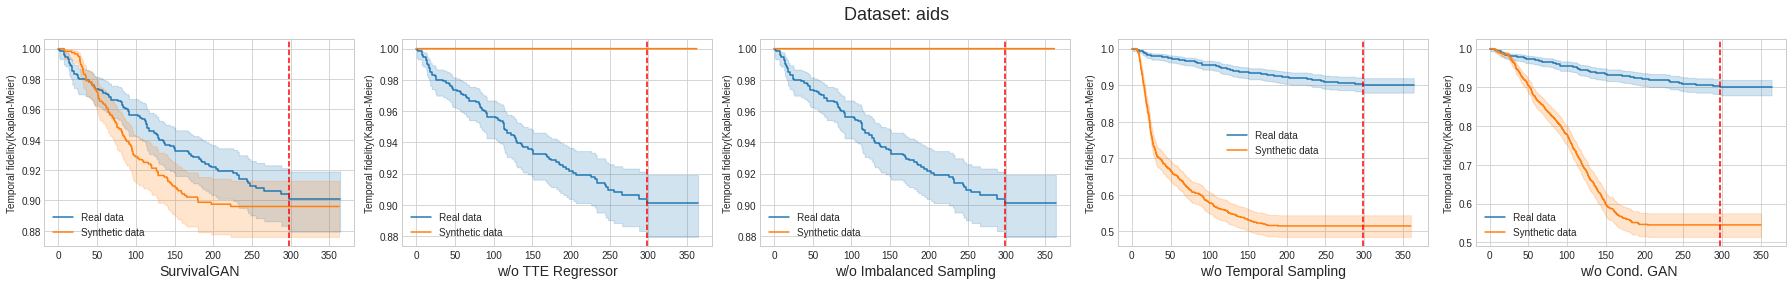

In [57]:
import warnings

warnings.filterwarnings("ignore")
plt.style.use("seaborn-whitegrid")

plot_gain_simple("aids")

In [49]:
plot_short_sight("cutract")

,model,sight
0,w/o TTE Regresso,0.1168 +/- 0.077
0,w/o Imbalanced Sampling,0.0639 +/- 0.0596
0,w/o Temporal Sampling,0.0512 +/- 0.0689
0,w/o Cond. GAN,0.1273 +/- 0.033


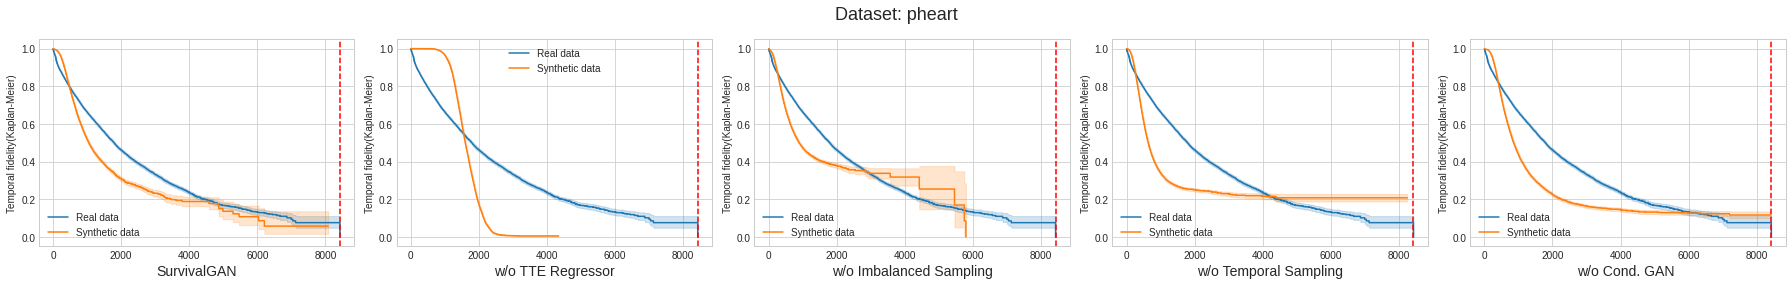

In [58]:
plot_gain_simple("maggic", repeat=1)

In [54]:
plot_short_sight("seer")

file not found  workspace/5872792679937530807_survival_gan{"dataloader_sampling_strategy": "none", "tte_strategy": "survival_function", "uncensoring_model": "date", "use_conditional": false}_0.bkp
file not found  workspace/5872792679937530807_survival_gan{"dataloader_sampling_strategy": "none", "tte_strategy": "survival_function", "uncensoring_model": "date", "use_conditional": false}_1.bkp
file not found  workspace/5872792679937530807_survival_gan{"dataloader_sampling_strategy": "none", "tte_strategy": "survival_function", "uncensoring_model": "date", "use_conditional": false}_2.bkp
file not found  workspace/5872792679937530807_survival_gan{"dataloader_sampling_strategy": "none", "tte_strategy": "survival_function", "uncensoring_model": "date", "use_conditional": false}_3.bkp
file not found  workspace/5872792679937530807_survival_gan{"dataloader_sampling_strategy": "none", "tte_strategy": "survival_function", "uncensoring_model": "survival_function_regression", "use_conditional": fals

,model,sight
0,w/o TTE Regresso,nan +/- nan
0,w/o Imbalanced Sampling,0.1322 +/- 0.1136
0,w/o Temporal Sampling,0.1453 +/- 0.0487
0,w/o Cond. GAN,0.0494 +/- 0.0119


In [52]:
## Plot optimism